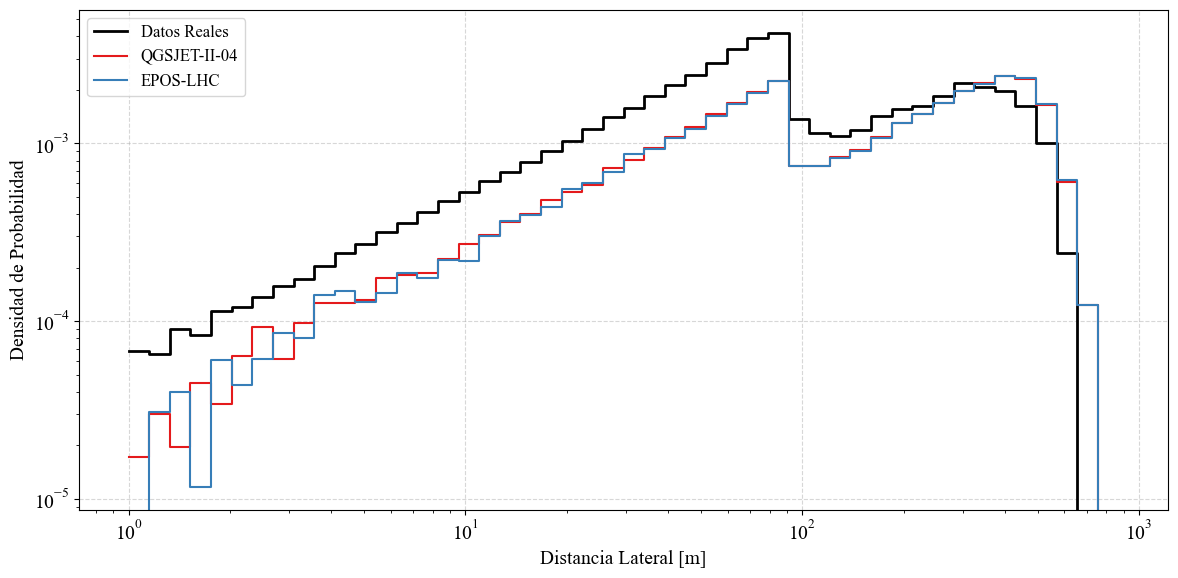

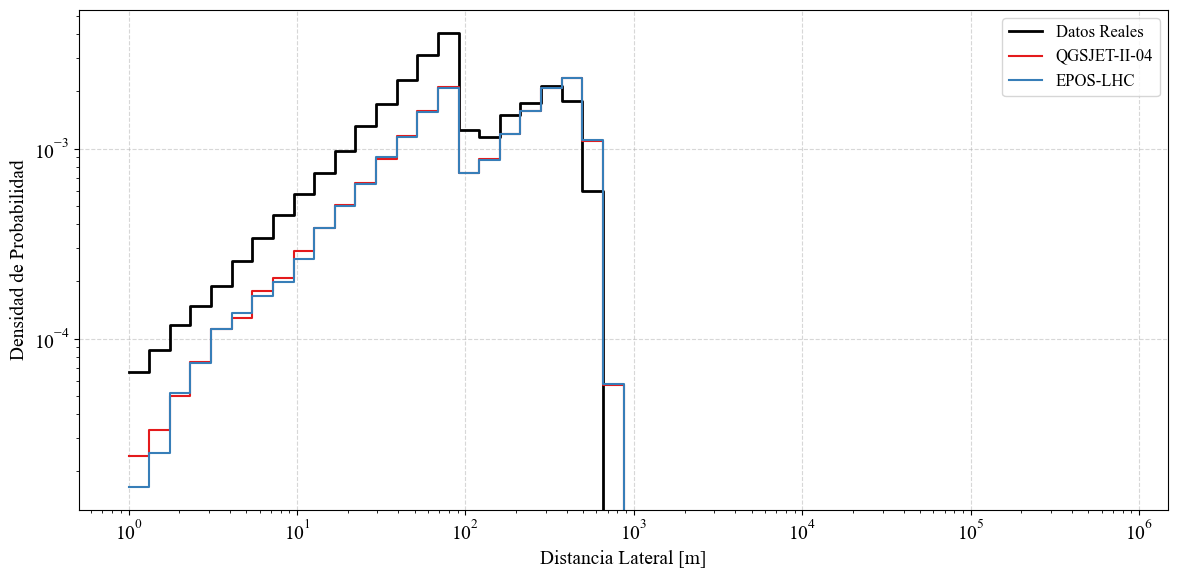

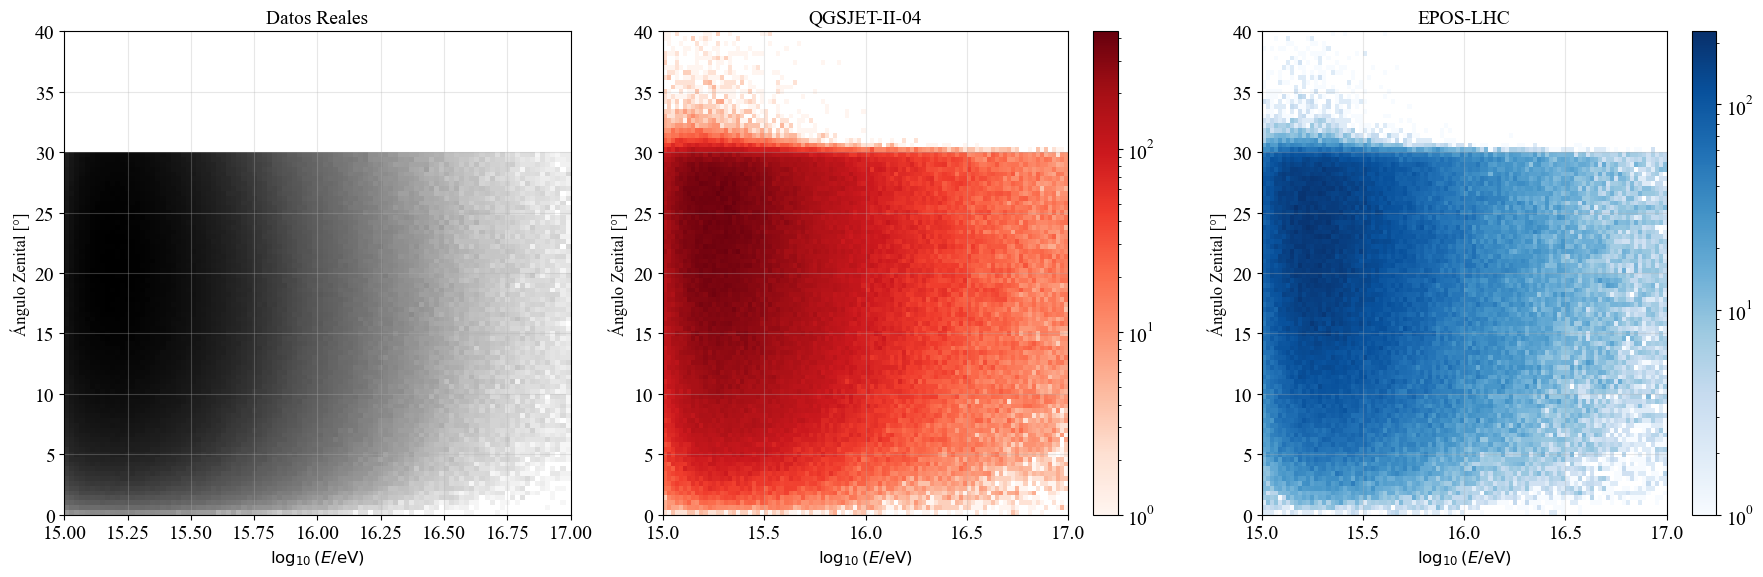

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, pearsonr
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from scipy.stats import chisquare

# --- Configuración ISO 690 ---
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Times New Roman'
rcParams['font.size'] = 14

# --- Rutas Exactas y Modelos ---
BASE_PATH = "C:/Users/MSI/extraidos/"
REAL_FILE = f"{BASE_PATH}events.root"

FILES = {
    "QGSJET-II-04": {
        "Proton": f"{BASE_PATH}COMBINED_Sim_qgs-4_pr1.root",
        "Helium": f"{BASE_PATH}COMBINED_Sim_qgs-4_he1.root",
        "Carbon": f"{BASE_PATH}COMBINED_Sim_qgs-4_co1.root",
        "Silicon": f"{BASE_PATH}COMBINED_Sim_qgs-4_si1.root",
        "Iron": f"{BASE_PATH}COMBINED_Sim_qgs-4_fe1.root",
        "Gamma": f"{BASE_PATH}COMBINED_Sim_qgs-4_gm1.root"
    },
    "EPOS-LHC": {
        "Proton": f"{BASE_PATH}COMBINED_Sim_epos-LHC_pr.root",
        "Helium": f"{BASE_PATH}COMBINED_Sim_epos-LHC_he.root",
        "Carbon": f"{BASE_PATH}COMBINED_Sim_epos-LHC_co.root",
        "Silicon": f"{BASE_PATH}COMBINED_Sim_epos-LHC_si.root",
        "Iron": f"{BASE_PATH}COMBINED_Sim_epos-LHC_fe.root",
        "Gamma": f"{BASE_PATH}COMBINED_Sim_epos-LHC_gm.root"
    }
}

# --- Función para Cargar Datos Simulados ---
def load_simulated_data(model, particle_type="muones"):
    """Carga datos simulados para un modelo y tipo de partícula específicos."""
    particles = []
    r_values = []
    energies = []
    
    for primary in FILES[model].values():
        with uproot.open(primary) as file:
            tree = file["comb;1"]
            data = tree.arrays(["Nmu" if particle_type=="muones" else "Ne", "Xc", "Yc", "E"], library="np")
            particles.extend(data["Nmu" if particle_type=="muones" else "Ne"])
            r_values.extend(np.sqrt(data["Xc"]**2 + data["Yc"]**2))
            energies.extend(10**data["E"])
    
    return np.array(particles), np.array(r_values), np.array(energies)

# --- Función para Cargar Datos Reales ---
def load_real_data(particle_type="muones"):
    """Carga datos reales desde el archivo events.root."""
    with uproot.open(REAL_FILE) as file:
        tree = file["combined"]
        data = tree.arrays(["Nmu" if particle_type=="muones" else "Ne", "Xc", "Yc", "E"], library="np")
        particles = 10**data["Nmu" if particle_type=="muones" else "Ne"]
        r = np.sqrt(data["Xc"]**2 + data["Yc"]**2)
        energy = 10**data["E"]
    return particles, r, energy

# --- Análisis Comparativo ---
def comparative_analysis(particle_type="muones", energy_range=(1e15, 1e17)):
    """Realiza análisis comparativo completo."""
    # Cargar datos
    real_part, real_r, real_energy = load_real_data(particle_type)
    models_data = {
        model: load_simulated_data(model, particle_type) 
        for model in FILES.keys()
    }
    
    # Filtrar por energía
    mask_real = (real_energy >= energy_range[0]) & (real_energy <= energy_range[1])
    
    # Gráficos de distribución lateral
    plt.figure(figsize=(12, 6))
    bins = np.logspace(0, 3, 50) if particle_type=="muones" else np.logspace(0, 6, 50)
    
    # Datos reales
    hist_real, edges = np.histogram(real_r[mask_real], bins=bins, density=True)
    plt.step(edges[:-1], hist_real, where='post', label='Datos Reales', color='k', lw=2)
    
    # Modelos
    for model, (particles, r, energy) in models_data.items():
        mask = (energy >= energy_range[0]) & (energy <= energy_range[1])
        hist, _ = np.histogram(r[mask], bins=edges, density=True)
        plt.step(edges[:-1], hist, where='post', label=model, 
        ls='-' if model=="QGSJET-II-04" else '-',  # QGSJET línea sólida
        color='#e41a1c' if model=="QGSJET-II-04" else '#377eb8')
    
    # Ajustes visuales
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Distancia Lateral [m]', fontsize=14)
    plt.ylabel('Densidad de Probabilidad', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5, ls='--')
    plt.tight_layout()
    plt.savefig(f"{BASE_PATH}Comparacion_Lateral_{particle_type}.pdf", dpi=600)
    plt.show()

# --- Análisis Energía-Zenital (2D Histogram) ---
def energy_zenith_correlation():
    """Comparación de la correlación energía-ángulo zenital."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Datos reales
    with uproot.open(REAL_FILE) as file:
        real_data = file["combined"].arrays(["E", "Ze"], library="np")
        real_energy = 10**real_data["E"]
        real_ze = real_data["Ze"]
        h_real = axs[0].hist2d(np.log10(real_energy), real_ze, bins=100, 
                              range=((15, 17), (0, 40)), cmap='Greys', norm=LogNorm())
        axs[0].set_title('Datos Reales', fontsize=14)
    
    # Modelos
    for idx, model in enumerate(FILES.keys(), 1):
        energies = []
        ze_angles = []
        for primary in FILES[model].values():
            with uproot.open(primary) as file:
                data = file["comb;1"].arrays(["E", "Ze"], library="np")
                energies.extend(10**data["E"])
                ze_angles.extend(data["Ze"])
        
        h = axs[idx].hist2d(np.log10(energies), ze_angles, bins=100, 
                           range=((15, 17), (0, 40)), 
                           cmap='Reds' if model=="QGSJET-II-04" else 'Blues', 
                           norm=LogNorm())
        axs[idx].set_title(model, fontsize=14)
        plt.colorbar(h[3], ax=axs[idx])
    
    for ax in axs:
        ax.set_xlabel(r'$\log_{10}(E/\mathrm{eV})$', fontsize=12)
        ax.set_ylabel('Ángulo Zenital [°]', fontsize=12)
        ax.grid(alpha=0.3)
        
   
    plt.tight_layout()
    plt.savefig(f"{BASE_PATH}Correlacion_Energia_Zenital.pdf", dpi=600)
    plt.show()

# --- Ejecución Principal ---
if __name__ == "__main__":
    comparative_analysis(particle_type="muones")
    comparative_analysis(particle_type="electrones")
    energy_zenith_correlation()

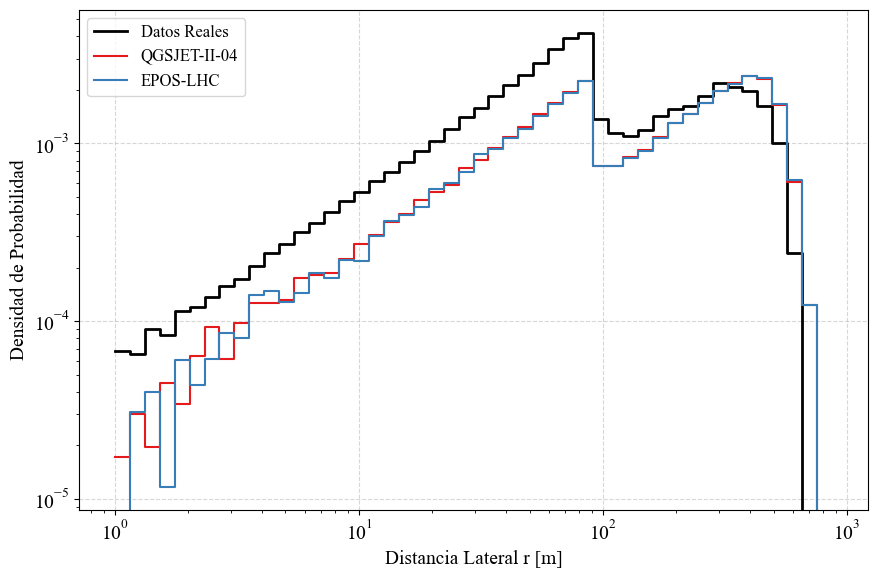


--- Métricas para Muones ---

Modelo: QGSJET-II-04
KS-test: D = 0.165, p = 0.00e+00
Chi² = 2813623.9
Pearson r = 0.947

Modelo: EPOS-LHC
KS-test: D = 0.168, p = 0.00e+00
Chi² = 243360002895172.0
Pearson r = 0.945


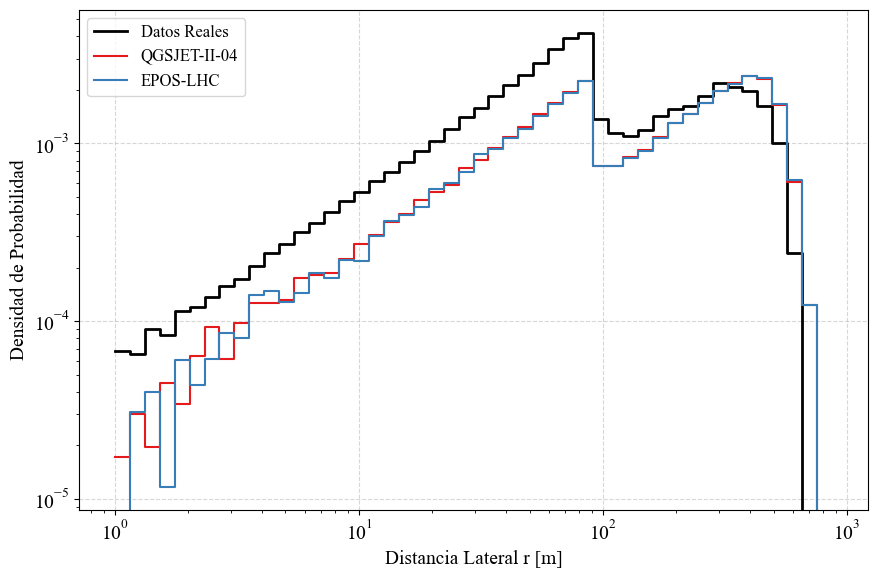


--- Métricas para Electrones ---

Modelo: QGSJET-II-04
KS-test: D = 0.165, p = 0.00e+00
Chi² = 2813623.9
Pearson r = 0.947

Modelo: EPOS-LHC
KS-test: D = 0.168, p = 0.00e+00
Chi² = 243360002895172.0
Pearson r = 0.945


In [19]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, pearsonr, chisquare
from matplotlib import rcParams

# --- Configuración ISO 690 ---
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Times New Roman'
rcParams['font.size'] = 14

# --- Rutas Exactas y Modelos ---
BASE_PATH = "C:/Users/MSI/extraidos/"
REAL_FILE = f"{BASE_PATH}events.root"

FILES = {
    "QGSJET-II-04": {
        "Proton": f"{BASE_PATH}COMBINED_Sim_qgs-4_pr1.root",
        "Helium": f"{BASE_PATH}COMBINED_Sim_qgs-4_he1.root",
        "Carbon": f"{BASE_PATH}COMBINED_Sim_qgs-4_co1.root",
        "Silicon": f"{BASE_PATH}COMBINED_Sim_qgs-4_si1.root",
        "Iron": f"{BASE_PATH}COMBINED_Sim_qgs-4_fe1.root",
        "Gamma": f"{BASE_PATH}COMBINED_Sim_qgs-4_gm1.root"
    },
    "EPOS-LHC": {
        "Proton": f"{BASE_PATH}COMBINED_Sim_epos-LHC_pr.root",
        "Helium": f"{BASE_PATH}COMBINED_Sim_epos-LHC_he.root",
        "Carbon": f"{BASE_PATH}COMBINED_Sim_epos-LHC_co.root",
        "Silicon": f"{BASE_PATH}COMBINED_Sim_epos-LHC_si.root",
        "Iron": f"{BASE_PATH}COMBINED_Sim_epos-LHC_fe.root",
        "Gamma": f"{BASE_PATH}COMBINED_Sim_epos-LHC_gm.root"
    }
}

# --- Función para Cargar Datos Simulados ---
def load_simulated_data(model, particle_type="muones"):
    """Carga datos simulados para un modelo y tipo de partícula específicos."""
    particles = []
    r_values = []
    energies = []
    
    for primary in FILES[model].values():
        with uproot.open(primary) as file:
            tree = file["comb;1"]
            data = tree.arrays(["Nmu" if particle_type=="muones" else "Ne", "Xc", "Yc", "E"], library="np")
            particles.extend(data["Nmu" if particle_type=="muones" else "Ne"])
            r_values.extend(np.sqrt(data["Xc"]**2 + data["Yc"]**2))
            energies.extend(10**data["E"])
    
    return np.array(particles), np.array(r_values), np.array(energies)

# --- Función para Cargar Datos Reales ---
def load_real_data(particle_type="muones"):
    """Carga datos reales desde el archivo events.root."""
    with uproot.open(REAL_FILE) as file:
        tree = file["combined"]
        data = tree.arrays(["Nmu" if particle_type=="muones" else "Ne", "Xc", "Yc", "E"], library="np")
        particles = 10**data["Nmu" if particle_type=="muones" else "Ne"]
        r = np.sqrt(data["Xc"]**2 + data["Yc"]**2)
        energy = 10**data["E"]
    return particles, r, energy

# --- Análisis Comparativo ---
def comparative_analysis(particle_type="muones", energy_range=(1e15, 1e17)):
    """Realiza análisis comparativo completo."""
    # Cargar datos
    real_part, real_r, real_energy = load_real_data(particle_type)
    models_data = {
        model: load_simulated_data(model, particle_type) 
        for model in FILES.keys()
    }
    
    # Filtrar por energía
    mask_real = (real_energy >= energy_range[0]) & (real_energy <= energy_range[1])
    
    # Gráficos de distribución lateral
    plt.figure(figsize=(9, 6))
    bins = np.logspace(0, 3, 50) if particle_type=="muones" else np.logspace(0, 3, 50)
    
    # Histograma de datos reales (counts y densidad)
    real_counts, edges = np.histogram(real_r[mask_real], bins=bins)
    bin_widths = np.diff(edges)
    real_density = real_counts / (np.sum(real_counts) * bin_widths)
    plt.step(edges[:-1], real_density, where='post', label='Datos Reales', color='k', lw=2)
    
    stats_results = {}
    
    # Procesar cada modelo
    for model, (particles, r, energy) in models_data.items():
        mask = (energy >= energy_range[0]) & (energy <= energy_range[1])
        model_r_masked = r[mask]
        
        # Histograma del modelo (counts y densidad)
        model_counts, _ = np.histogram(model_r_masked, bins=edges)
        model_density = model_counts / (len(model_r_masked) * bin_widths)
        
        # Escalar conteos para comparación estadística
        if model_counts.sum() == 0:
            scale_factor = 0
        else:
            scale_factor = real_counts.sum() / model_counts.sum()  # Ajuste clave
        scaled_counts = model_counts * scale_factor
        
        # Manejar ceros en expected y mantener suma igual a real_counts.sum()
        epsilon = 1e-10
        f_exp = scaled_counts + epsilon  # Evitar ceros
        f_exp *= real_counts.sum() / f_exp.sum()  # Renormalizar
        f_exp = scaled_counts + 1e-10  # Evitar división por cero
        
        # Tests estadísticos
        D, p_value = ks_2samp(real_r[mask_real], model_r_masked)
        chi2_stat = chisquare(real_counts, f_exp=f_exp)[0]
        pearson_corr, _ = pearsonr(real_counts, scaled_counts)
        
        stats_results[model] = {
            'KS_D': D,
            'KS_p': p_value,
            'Chi2': chi2_stat,
            'Pearson': pearson_corr
        }
        
        # Plot densidad del modelo
        plt.step(edges[:-1], model_density, where='post', label=model, 
                 ls='-' if model=="QGSJET-II-04" else '-', 
                 color='#e41a1c' if model=="QGSJET-II-04" else '#377eb8')
    
    # Ajustes visuales
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Distancia Lateral r [m]', fontsize=14)
    plt.ylabel('Densidad de Probabilidad', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5, ls='--')
    plt.tight_layout()
    plt.savefig(f"{BASE_PATH}Comparacion_Lateral_{particle_type}.pdf", dpi=700)
    plt.show()
    
    # Impresión de métricas
    print(f"\n--- Métricas para {particle_type.capitalize()} ---")
    for model, metrics in stats_results.items():
        print(f"\nModelo: {model}")
        print(f"KS-test: D = {metrics['KS_D']:.3f}, p = {metrics['KS_p']:.2e}")
        print(f"Chi² = {metrics['Chi2']:.1f}")
        print(f"Pearson r = {metrics['Pearson']:.3f}")

# --- Ejecución Principal ---
if __name__ == "__main__":
    comparative_analysis(particle_type="muones")
    comparative_analysis(particle_type="electrones")